In [55]:
import pandas as pd 
from selenobot.utils import DATA_DIR, dataframe_from_fasta, dataframe_to_fasta, dataframe_from_ko
from selenobot.extend import extend, translate
import os
import numpy as np
import subprocess
import time
from tqdm import tqdm 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings 
from selenobot.extend import extend
import sklearn
import scipy

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
VAL_DIR = os.path.join(DATA_DIR, 'validation', 'v3')

# Validation

Fitness data for each organism was obtained [here](https://figshare.com/articles/dataset/February_2024_release_of_the_Fitness_Browser_RB-TnSeq_data_for_diverse_bacteria_and_archaea/25236931/1).

There are a few things to try in order to get meaningful results from this data. As per Avi's advice, it is probably best to take a more directed look at the results. Start out by looking at the KEGG annotations for the hits, and seeing if they make sense. 

In [3]:
ORGANISMS = os.listdir(os.path.join(VAL_DIR, 'fitness')) # Each of the filenames is the name of the organism. :
ORGANISMS = [o.replace('db.StrainFitness.', '') for o in ORGANISMS if o != 'aaseqs'] # Remove prefixes from filenames. 
print(f'Obtained fitness data for {len(ORGANISMS)} organisms.') # NOTE: I thought there was 51?

Obtained fitness data for 49 organisms.


In [4]:
# Download gene metadata for each organism, which contains the locations within the genomes. Put in the DATA_DIR.
for org in ORGANISMS:
    if f'{org}.tsv' not in os.listdir(os.path.join(VAL_DIR, 'metadata')): # Make sure not to download the file twice.
        output_file = os.path.join(VAL_DIR, 'metadata', f'{org}.tsv')
        subprocess.run(f'wget https://fit.genomics.lbl.gov/cgi-bin/orgGenes.cgi?orgId={org} -O {output_file}', shell=True, check=True)
        time.sleep(1)

In [5]:
# How many total genes are there?
genes_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'aaseqs.fa'), parse_header=False)
# Check to make sure we have about the right number of genes in the file...
print(len(genes_df), f'total genes obtained. This is about {np.round(len(genes_df) / len(ORGANISMS))} genes per organism.')

221030 total genes obtained. This is about 4511.0 genes per organism.


## Loading organism data

The amino acid sequences for every CDS for every organism is stored in the `aaseqs.fa` file. Metadata for the genes, which includes the scaffold, orientation, functional annotation, and start and end positions, is found in the corresponding `{organism}_metadata.tsv` file. 

A subset of the genes in `aaseqs.fa` for the particular organism are extracted and annotated with KEGG ortholog (KO) groups. Additionally, they are embedded, and predictions are generated using the trained selenoprotein classifier.

In [6]:
organism = 'acidovorax_3H11'

In [7]:
# First, we need to generate a FASTA file containing only the genes from the specified organism. 
organism_genes_df = genes_df[genes_df['id'].str.contains(organism)] # Get all sequences for the specified organism.
dataframe_to_fasta(organism_genes_df, os.path.join(VAL_DIR, 'genes', f'{organism}.fa')) # Convert to a FASTA file so it can be used with the scripts. 
print(len(organism_genes_df), f'genes belonging to {organism}.')

4964 genes belonging to acidovorax_3H11.


In [8]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, 'predictions', f'{organism}.csv')) # Load selenoprotein predictions. 
annotations_df = dataframe_from_ko(os.path.join(VAL_DIR, 'annotations', f'{organism}.fa.ko'), parse_header=True) # Load KEGG annotations. 
metadata_df = pd.read_csv(os.path.join(VAL_DIR, 'metadata', f'{organism}.tsv'), delimiter='\t') # Load the gene metadata.

metadata_df['id'] = metadata_df.locusId # Create an ID column to match the columns in the other DataFrames.
predictions_df['id'] = predictions_df['id'].str.replace(f'id={organism}:', '') # Remove extra stuff from ID to be compatible with annotations_df.
annotations_df['id'] = annotations_df['id'].str.replace(f'{organism}:', '') # Remove extra stuff from ID to be compatible with predictions_df.

# Combine the predictions, annotations, and metadata. 
df = predictions_df.merge(annotations_df[['ko', 'id']], on='id', how='outer')
df = df.merge(metadata_df, on='id', how='inner') # For some reason, there are more metadata entries than genes.

annotated_sec = df[~df.ko.isnull() & (df.prediction == 1)]
print(len(annotated_sec), 'predicted selenoproteins were successfully assigned a KO group.')
print(len(annotations_df), 'proteins were successfully assigned a KO group.')

1 predicted selenoproteins were successfully assigned a KO group.
2711 proteins were successfully assigned a KO group.


In [9]:
# As a control, are any proteins predicted to be in KO groups which are heavily-represented in the selenoprotein training set?
# sec_kos = dataframe_from_ko(os.path.join(DATA_DIR, 'sec.fasta.ko')).ko.values
# sec_ko_counts = [np.sum(sec_kos == ko) for ko in sec_kos]
# len(annotations_df[annotations_df.ko.isin(sec_kos)])

In [10]:
print('Number of predicted selenoproteins:', np.sum(df.prediction.values))
print('Average length of predicted selenoproteins:', df[df.prediction == 1].seq.apply(len).mean())
print('Average length of predicted non-selenoproteins:', df[df.prediction == 0].seq.apply(len).mean())

Number of predicted selenoproteins: 55.0
Average length of predicted selenoproteins: 75.43636363636364
Average length of predicted non-selenoproteins: 318.8684049704624


## Extending predicted selenoproteins

In [11]:
# Load the genome into a DataFrame which maps the scaffold ID to the scaffold sequence.
genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', f'{organism}.fna'), parse_header=False).rename(columns={'id':'scaffold_id'})

In [12]:
extensions_df = []

for id_ in df[df.prediction == 1]['id'].values:
    row = dict()

    id_df = df[df['id'].str.fullmatch(id_)] # Get entries for the locus ID. 
    row['start'], row['stop'], row['orientation'] = id_df.begin.item(), id_df.end.item(), id_df.strand.item()

    scaffold_id = id_df.scaffoldId.item()
    contig = genome_df[genome_df.scaffold_id.str.fullmatch(scaffold_id)].seq.item()

    row.update(extend(contig=contig, **row))
    row['id'] = id_ # Add the ID after extending.
    row['scaffold_id'] = scaffold_id # Add the scaffold ID too...
    extensions_df.append(row)

extensions_df = pd.DataFrame(extensions_df)
extensions_df['seq'] = extensions_df.apply(lambda row : translate(row['seq'], orientation=row['orientation']), axis=1)

In [13]:
stop_codons = set(extensions_df.stop_codon.values)
stop_codon_counts = {c:np.sum(extensions_df.stop_codon.values == c) for c in stop_codons}
print(stop_codon_counts)

{'TAA': 8, 'TGA': 30, 'TAG': 17}


In [14]:
dataframe_to_fasta(extensions_df, f'{organism}.fa.ext')

## Analyzing fitness data

The fitness data is pretty noisy, so I am going to need to think of approaches which will limit the effect of the noise. 

One idea (from Josh) is to use the fitness value distribution for a specific feature (i.e. experimental condition) to generate p-values for (1) fitness value for transposon insertions within the predicted gene bounds (2) fitness values for transposon insertions in the extended region. Then I can compare the p-value distributions, maybe using KL divergence. 

In [15]:
fitness_df = pd.read_csv(os.path.join(VAL_DIR, 'fitness', f'db.StrainFitness.{organism}'), delimiter='\t')

In [51]:
def filter_fitness_df(fitness_df:pd.DataFrame, mask_only:bool=False, exclude:bool=False, start:int=None, stop:int=None, scaffold_id:str=None, strand:str=None):
    '''Obtain fitness data for mutants where the inserted transposon lies within the specified region.'''
    mask = fitness_df.scaffold.str.fullmatch(scaffold_id)  # Get all entries on the same scaffold as the locus.
    mask = np.logical_and(mask, fitness_df.strand == strand) # Get all entries on the same strand as the locus.
    mask = np.logical_and(mask, (fitness_df.pos <= stop) & (fitness_df.pos >= start)) # Get all in-window mutations.

    if mask_only:
        return ~mask if exclude else mask
    else:
        return fitness_df[~mask] if exclude else fitness_df[mask]
    

def get_extension_window(start:int=None, stop:int=None, nt_ext:int=None, orientation:str=None, scaffold_id:str=None, **kwargs):
    '''Use the original start and stop locations, as well as the size of the extension, to get the window for the extension region of the
    predicted selenoprotein.'''
    if orientation == '-':
        ext_stop = start 
        ext_start = start - nt_ext - 1 # Not 100 percent sure I should be subtracting one again, but I think so?
    if orientation == '+':
        ext_stop = stop + nt_ext
        ext_start = stop
    return {'start':ext_start, 'stop':ext_stop, 'strand':orientation, 'scaffold_id':scaffold_id}


def get_window(start:int=None, stop:int=None, orientation:str=None, scaffold_id:str=None, **kwargs):
    '''Use the original start and stop locations to get information for the non-extended gene window.'''   
    return {'start':start, 'stop':stop, 'strand':orientation, 'scaffold_id':scaffold_id}


In [17]:
# First, I want to get a sense of how many hits in the fitness DataFrame there are for each predicted selenoprotein.
n_hits_extension, n_hits = [], []
for row in extensions_df.itertuples(index=False):
    filter_ = get_extension_window(**row._asdict())
    n_hits_extension.append(len(filter_fitness_df(fitness_df, **filter_)))
    filter_ = get_window(**row._asdict())
    n_hits.append(len(filter_fitness_df(fitness_df, **filter_)))

extensions_df['n_hits_extension'] = n_hits_extension
extensions_df['n_hits'] = n_hits
# Ac3H11_4927
extensions_df

,start,stop,orientation,seq,stop_codon,nt_ext,aa_ext,id,scaffold_id,n_hits_extension,n_hits
0,160290,160406,-,MALQVLKSDTSVKVGVQAKRKRAGWDVGYLAHVLGIRVUMRLPCGHVA,TAG,30,10,Ac3H11_1043,scaffold5/25,0,1
1,5228,5365,+,LSREGPAQSLRVVTCASAAAAQQKAPGSRFGCQGLWGVDGVAAYSU...,TAG,369,123,Ac3H11_1054,scaffold5/17,2,0
2,1854,1970,-,MALQVLKSDTSVKVGVQAKRKRAGWDVGYLAHVLGIRVUMRLPCG,TAG,21,7,Ac3H11_1067,scaffold5/11,0,0
3,4069,4191,+,MAKGSGRHTQGVAGNKKKGVEGGGERAHGFVCITAFLGRLUERAVR...,TAG,84,28,Ac3H11_1168,scaffold5/14,1,6
4,13577,13795,-,LSPISVGLHIFCGAPHPGPGGPAAWCVGCISPPLCMRAQPRASSMA...,TGA,6,2,Ac3H11_1175,scaffold5/14,0,2
5,93646,93783,-,MVRGAGVRGPVGEAQSIVGARGRRVSRGWLAHLPRRWWIGHHAWPU...,TAG,195,65,Ac3H11_1275,scaffold5/13,0,2
6,13560,13673,-,MTDPFVSVDLDTADSPHYLRALTDMADRRTVVADAAIUG,TAG,6,2,Ac3H11_128,scaffold5/35,0,2
7,119454,119570,-,MALQVLKSDTSVKVGVQAKRKRAGWDVGYLAHVLGIRVUMRLPCHH...,TAG,54,18,Ac3H11_1305,scaffold5/13,0,2
8,42578,42778,-,VGHGAMGDCDLGAAKALLQGVSRCQAWACRTRPPFAQWLHQPRGLP...,TGA,48,16,Ac3H11_1463,scaffold5/19,2,4
9,105719,105853,-,MVVVLVVIARTATPARAAVAVFRANGRAANIGCDCSGSGPITVFUA...,TGA,69,23,Ac3H11_1529,scaffold5/19,0,0


In [44]:
def plot_fitness_distribution(fitness_df:pd.DataFrame, condition:str=None, ax:plt.Axes=None):
    '''Plot the distribution of fitness values across a specific experimental condition.'''
    fitness_vals = fitness_df[condition].values
    
    n_bins = 50
    # y_vals, bin_edges, _, = ax.hist(fitness_vals, density=True, bins=n_bins)
    _, _, plot = ax.hist(fitness_vals, density=True)
    x_vals = np.linspace(min(fitness_vals), max(fitness_vals), 100)
    y_vals = scipy.stats.norm.pdf(x_vals, loc=np.mean(fitness_vals), scale=np.std(fitness_vals))
    # ax.plot(x_vals, y_vals, lw=1, c=plot[0]._facecolor)

    ax.set_xlabel('fitness')
    ax.set_title(f'Probability distribution of fitness values ({condition})')
   

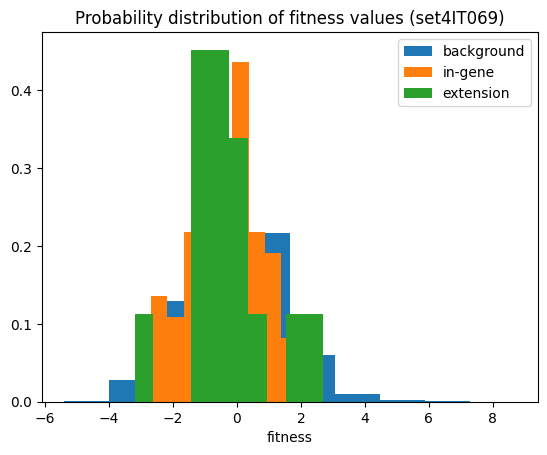

In [68]:
fig, ax = plt.subplots()

id_ = 'Ac3H11_4581'
condition = conditions[1]
kwargs = extensions_df[extensions_df['id'].str.fullmatch(id_)].to_dict(orient='records')[0]
filter_ = get_window(**kwargs)
filter_ext = get_extension_window(**kwargs)

plot_fitness_distribution(fitness_df, condition=condition, ax=ax)
plot_fitness_distribution(filter_fitness_df(fitness_df, **filter_), condition=condition, ax=ax)
plot_fitness_distribution(filter_fitness_df(fitness_df, **filter_ext), condition=condition, ax=ax)
ax.legend(['background', 'in-gene', 'extension'])

plt.show()

In [69]:
# For each ID, I want to find the experimental conditions for which the distribution of fitness values for in-gene mutations
# is the most different from the background. 

# NOTE: Should I exclude the in-gene mutations from the background? Probably yes, although I doubt it will have much effect. 

def get_ks_scores(fitness_df:pd.DataFrame, extensions_df:pd.DataFrame, id_:str='Ac3H11_4927'):
    '''For a given locus, calculate the KL divergence between the distribution of fitness values from in-gene mutations to 
    the "background" distribution of fitness values.'''
    # Get the info for the specified locus from the extensions DataFrame. 
    id_kwargs = extensions_df[extensions_df['id'].str.fullmatch(id_)].to_dict(orient='records')[0]
    
    in_gene_fitness_df = filter_fitness_df(fitness_df, **get_window(**id_kwargs))
    background_fitness_df = filter_fitness_df(fitness_df, exclude=True, **get_window(**id_kwargs))

    ks_df = []

    exclude_cols = ['barcode', 'scaffold', 'strand', 'pos', 'locusId', 'used']
    for col in [col for col in fitness_df.columns if col not in exclude_cols]:
        background_fitness_vals = background_fitness_df[col].values
        in_gene_fitness_vals = in_gene_fitness_df[col].values
        # If the KS statistic is large, then the p-value will be small, and this may be taken as evidence against the null hypothesis
        # in favor of the alternative. In this case, the alternative is that the distributions are different. 
        ks = scipy.stats.ks_2samp(in_gene_fitness_vals, background_fitness_vals, alternative='two-sided')
        ks_df.append({'condition':col, 'statistic':ks.statistic, 'pvalue':ks.pvalue})
        
    return pd.DataFrame(ks_df).sort_values('pvalue')


In [70]:
ks_df = get_ks_scores(fitness_df, extensions_df)
ks_df = ks_df[ks_df.pvalue < 0.05]

In [73]:
conditions = ks_df.condition.values
print(len(conditions), 'significant conditions detected.')

5 significant conditions detected.


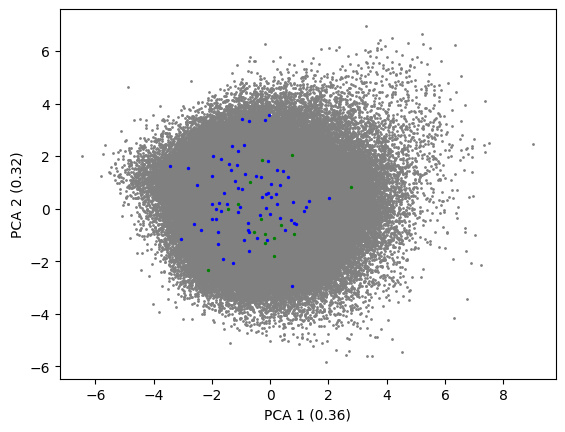

In [77]:
# For these "best" conditions, we want to generate comparison values between 

id_kwargs = extensions_df[extensions_df['id'].str.fullmatch(id_)].to_dict(orient='records')[0]

in_gene_mask = filter_fitness_df(fitness_df, mask_only=True, **get_window(**id_kwargs))
extension_mask = filter_fitness_df(fitness_df, mask_only=True, **get_extension_window(**id_kwargs)) 

n = len(fitness_df)
labels = ['in-gene' if in_gene_mask[i] else 'background' for i in range(n)]
labels = ['extension' if (extension_mask[i] and (not in_gene_mask[i])) else labels[i] for i in range(n)]

X = fitness_df[conditions].values
pca = sklearn.decomposition.PCA(n_components=2)
comps = pca.fit_transform(X)
exp_var = np.round(pca.explained_variance_ratio_, 2)

fig, ax = plt.subplots()
# color_map = {'in-gene':'tab:blue', 'extension':'tab:green', 'background':'gray'}
ax.scatter(comps[:, 0], comps[:, 1], c='gray', s=1)
ax.scatter(comps[in_gene_mask, 0], comps[in_gene_mask, 1], c='blue', s=2)
ax.scatter(comps[extension_mask, 0], comps[extension_mask, 1], c='green', s=2)
ax.set_xlabel(f'PCA 1 ({exp_var[0]})')
ax.set_ylabel(f'PCA 2 ({exp_var[1]})')
plt.show()
